<a href="https://colab.research.google.com/github/HarmanDotpy/Compressive_Sensing_Sparse_Signal/blob/master/6.One%20Dimensional%20Process%20and%20Innovation%20Sequence%2C%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import time
# while(1):
#   time.sleep(5)

Import Libraries

In [2]:
import torch
import torch.nn as nn 
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Implementing the stochastic process

In [3]:
# Process vector is x and its size  is q * 1
# N sensors , k * 1 measurement is made by each sensor
q = 1
N = 1
k = 1

#helper matrices to generate process matrices
mat = torch.FloatTensor(q,q).uniform_(0,1)
Zq = 0.1 * torch.FloatTensor(q, q).uniform_(-1,1)
Zr =  0.1 * torch.FloatTensor(k * N, k * N).uniform_(-1,1)

#Initialize Constant process matrices
A = 0.5 * (mat/mat.sum(1).view(q,1)) #singly - stochastic - matrix * factor
C = torch.FloatTensor(k * N,q).uniform_(0,1)
Q = torch.mm(Zq, Zq.T)
R = torch.mm(Zr, Zr.T)
xo = torch.FloatTensor(q, 1).uniform_(0,1)

print('A = \n{} \n\nC = \n{} \n\nQ = \n{} \n\nR = \n{} \n\nxo = \n{}'.format(A, C, Q, R, xo))
print(A.sum(1))

A = 
tensor([[0.5000]]) 

C = 
tensor([[0.8605]]) 

Q = 
tensor([[0.0015]]) 

R = 
tensor([[0.0001]]) 

xo = 
tensor([[0.9223]])
tensor([0.5000])


In [0]:
# Generating the stochastiic process
x = [xo]
y = []
z = []
for i in range(20000):
  
  # with noise
  x.append(torch.mm(A, x[-1]) + 5 * MultivariateNormal(torch.zeros(q), Q).sample().view(q,1))
  y.append(torch.mm(C, x[-1]) + 5 * MultivariateNormal(torch.zeros(k * N), R).sample().view(k * N,1))
x = torch.stack(x)
y = torch.stack(y)

Visualizing the Process

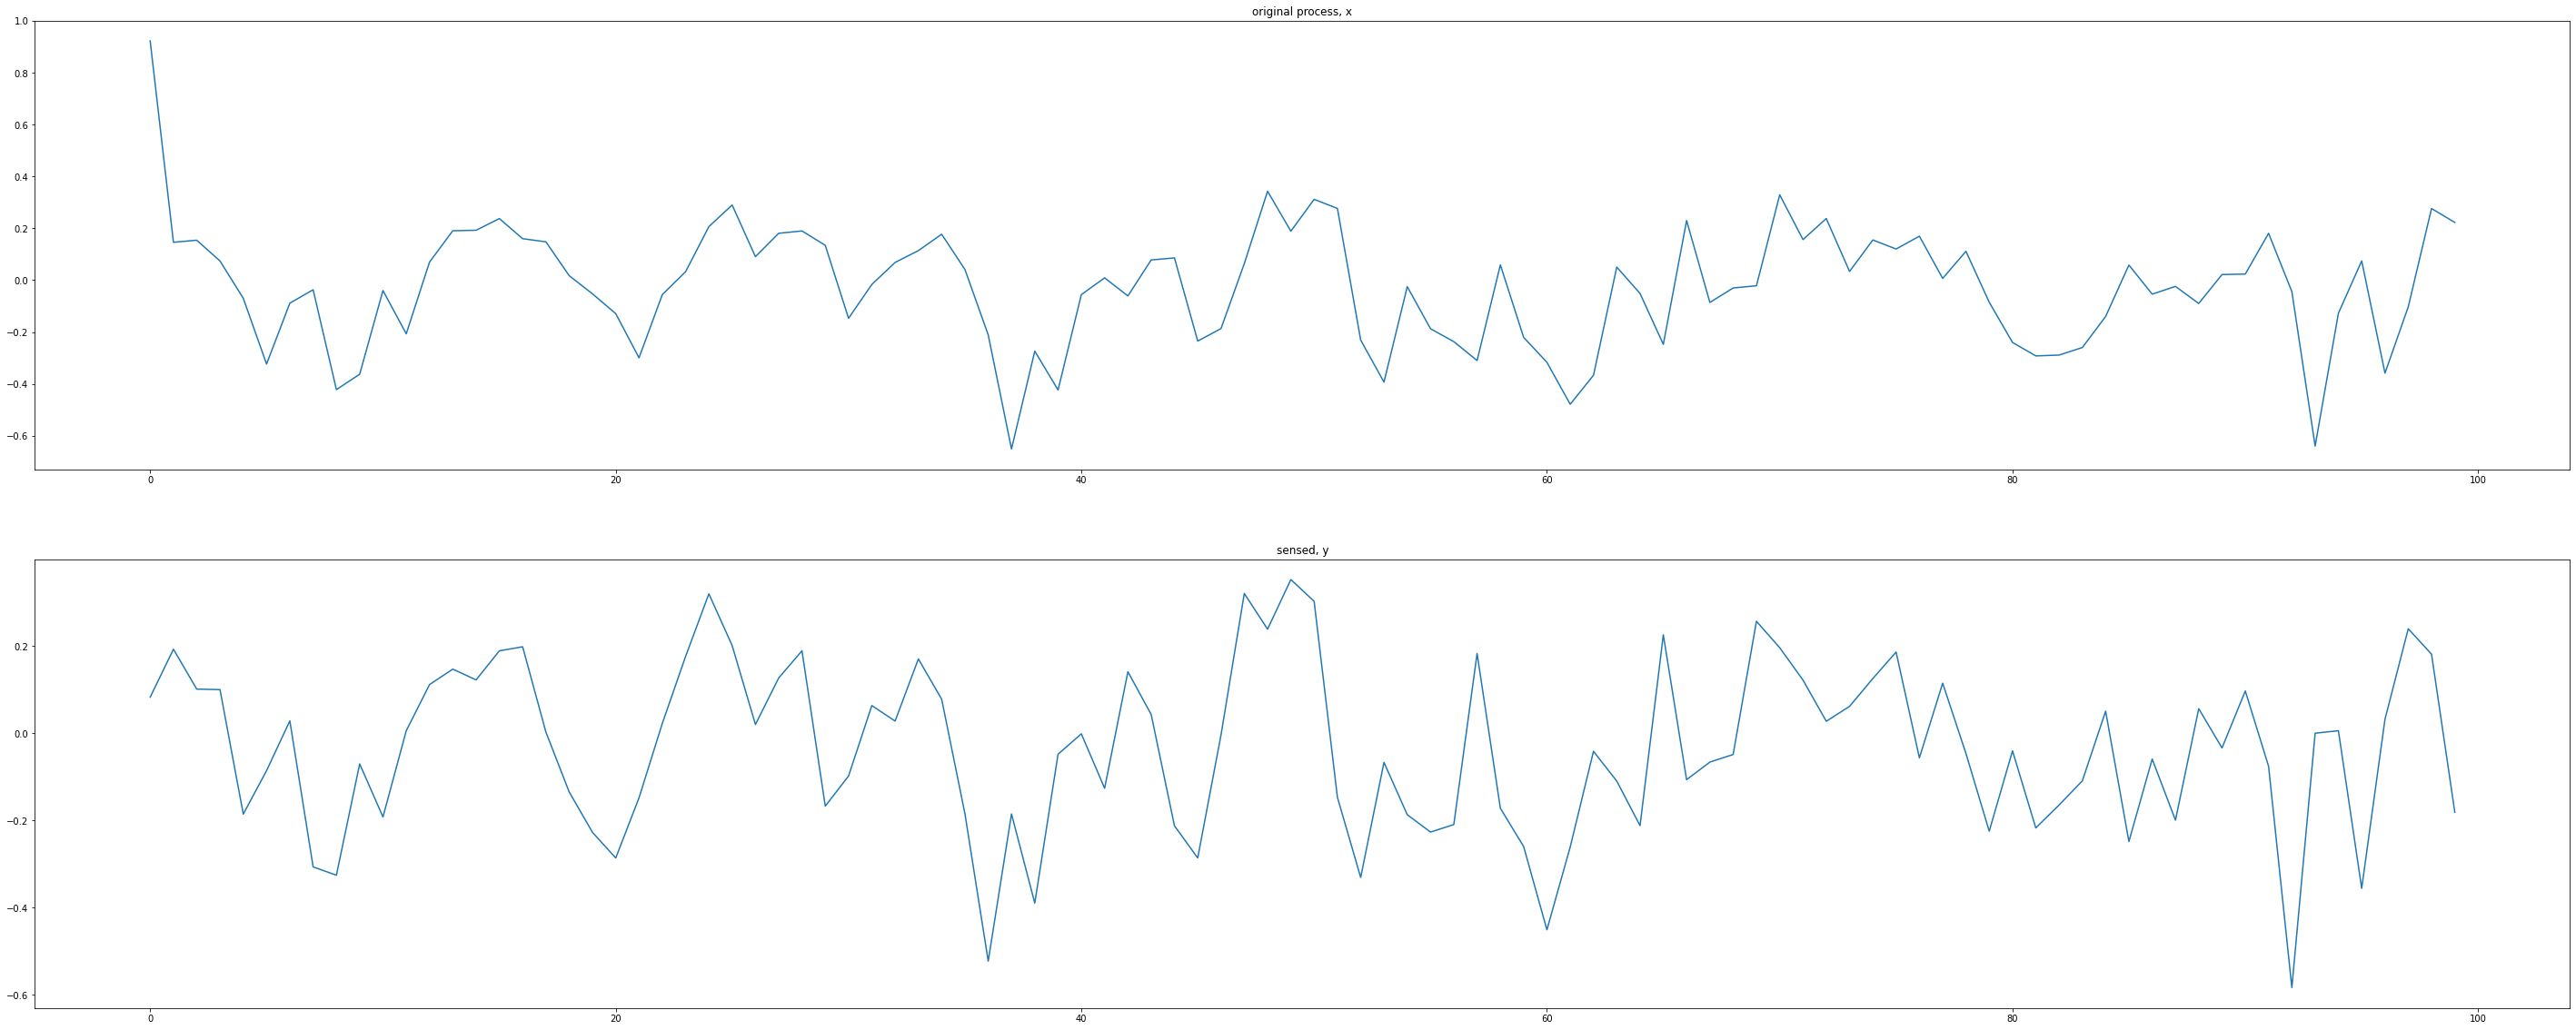

In [5]:
start, end = 0, 100
# x is q,1 and y is k*N,1 choose the indeces to visualize
x_index, y_index = 0,0
fig, axis = plt.subplots(2,1)
axis[0].plot(x[start:end,x_index])
axis[0].title.set_text('original process, x')
axis[1].plot(y[start:end,y_index])
axis[1].title.set_text('sensed, y')
fig.set_size_inches(w = 50, h = 20)
plt.show()

Making the deep learning model as a simple multilayer perceptron

In [0]:
class DeepNet(nn.Module):
  def __init__(self, s):
    super(DeepNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(s, 10 * s),
        nn.ReLU()
        )
    self.layer2 = nn.Sequential(
        nn.Linear(10 * s, 10 * s),
        nn.ReLU()
        )
    self.layer3 = nn.Sequential(
        nn.Linear(10 * s, s),
        nn.ReLU()
        )
    self.layer4 = nn.Sequential(
        nn.Linear(s,s)
        )
    # 4rd layer is used to not have any constraints in the output values. constraints are for example - grater than 0 in case of relu, b/w -1,1 in case of tanh and we dont desire that

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out) 
    out = self.layer4(out)
    
    return out

Coding and Fitting a Kalman Filter to get the estmate of the process x using the sensor values y.

In [0]:
def kalman(A, C, Q, R, y, process_size_q, xhat_prev, P_prev):
  '''
  prior means the prior estimate of the variable at current time For eg xhat_prior = xhat_k'
  prev means the value of the variable at the prev time instant For eg xhat_prev = xhat_k-1
  '''
  xhat_prior = torch.mm(A, xhat_prev)
  P_prior = torch.chain_matmul(A, P_prev, A.t()) + Q
  Sigma_z = torch.chain_matmul(C, P_prior, C.t()) + R
  K = torch.chain_matmul(P_prior, C.t(), torch.inverse(Sigma_z))

  # update values of estimate and the error covariance matrix at this instant
  xhat = xhat_prior + torch.mm(K, (y - torch.mm(C, xhat_prior)))
  P = torch.mm((torch.eye(process_size_q) - torch.mm(K, C)), P_prior)
  return xhat, P, Sigma_z

Some Helper Functions

In [0]:
class HelperDataset(Dataset):
    def __init__(self, LIST):
        self.samples = LIST
        # self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        n = self.samples[idx]
        return n

def loaddata(x, batchsize):
  dataset = HelperDataset(x)
  dataloader = DataLoader(dataset, batch_size = batchsize, shuffle = False)
  #shuffle = False is critical above due to the serial nature of z's 
  return dataloader

def FitKalman(z):
  # to return a tensor 
  global xhat_tilda, P_attacked
  # xhat_tilda.detach()
  x_batch = []
  for i in range(batchsize):
      y_attacked = z[i,:,:] +  torch.chain_matmul(C, A, xhat_tilda)
      xhat_tilda, P_attacked, Sigma_z_attacked = kalman(A, C, Q, R, y_attacked, q, x_attacked[-1], P_attacked)
      x_attacked.append(xhat_tilda.clone())
      x_batch.append(xhat_tilda.clone())
  x_batch = torch.stack(x_batch)
  return x_batch

Intercepting the y's sequentially, getting estimates of x, xhats, and getting innovation vectors z's. Inputting the z's to a Deep Learning model to output the attacked z~ which will be non linear.


1st Experiment - Simple multilayer perceptron, past 'n' innovation vectors as training examples, custom loss function. Online Learning with batch size  = some constant

Goal 
1.   To get the optimal learning rate and also see if we need 2 separate learning rates
2.   To get the number of iterations it takes to converge

In [9]:
# xhat = 0 and creating a PSD matrix P for initial step of the kalman filter
xhat = torch.zeros((q,1))
x_estimate = [xhat]
Zp = torch.FloatTensor(q,q).uniform_(-1,1)
P = torch.mm(Zp, Zp.t())

# initialize model and hyperparameters
model = DeepNet(N* k)
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
Lambda = 0.1 # for the loss function
mseloss_factor = 1
x_star = 3 * torch.ones((q,1)) # the value towards which we want to drive the estimate. For use in the loss function
# num_epochs = 10
batchsize = 25
print(model)

# values to save
loss_list = [] 
mseloss_list = []
chiloss_list = []
z_innovation = []
# chi square detector loss values
detector_values_true = []
# Keeping a track of the intermediate matrices
Sigma_z_list = []
P_list = []
# Steady state values of the matrices
Sigma_z_inf = 0
P_inf = 0

# attacked lists
xhat_tilda = xhat
P_attacked = P
z_attacked = []
x_attacked = [xhat_tilda]
detector_values_changed_z = []

def lossfunction(z_tilda_batch, Sigma_z, xhat_tilda_batch):
  # chi_squareloss = Lambda * torch.mm(torch.mm(torch.t(z_tilda), torch.inverse(Sigma_z)), z_tilda) 
  # distance_loss = 4 * nn.functional.mse_loss(xhat_tilda, x_star, reduction = 'sum')
  chi_squareloss = 0
  distance_loss = 0

  for i in range(batchsize):
    chi_squareloss += Lambda * torch.mm(torch.mm(torch.t(z_tilda_batch[i,:,:]), torch.inverse(Sigma_z)), z_tilda_batch[i,:,:]) 
    distance_loss += mseloss_factor * nn.functional.mse_loss(xhat_tilda_batch[i,:,:], x_star, reduction = 'sum')

  return distance_loss/batchsize, chi_squareloss/batchsize

DeepNet(
  (layer1): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)


[]

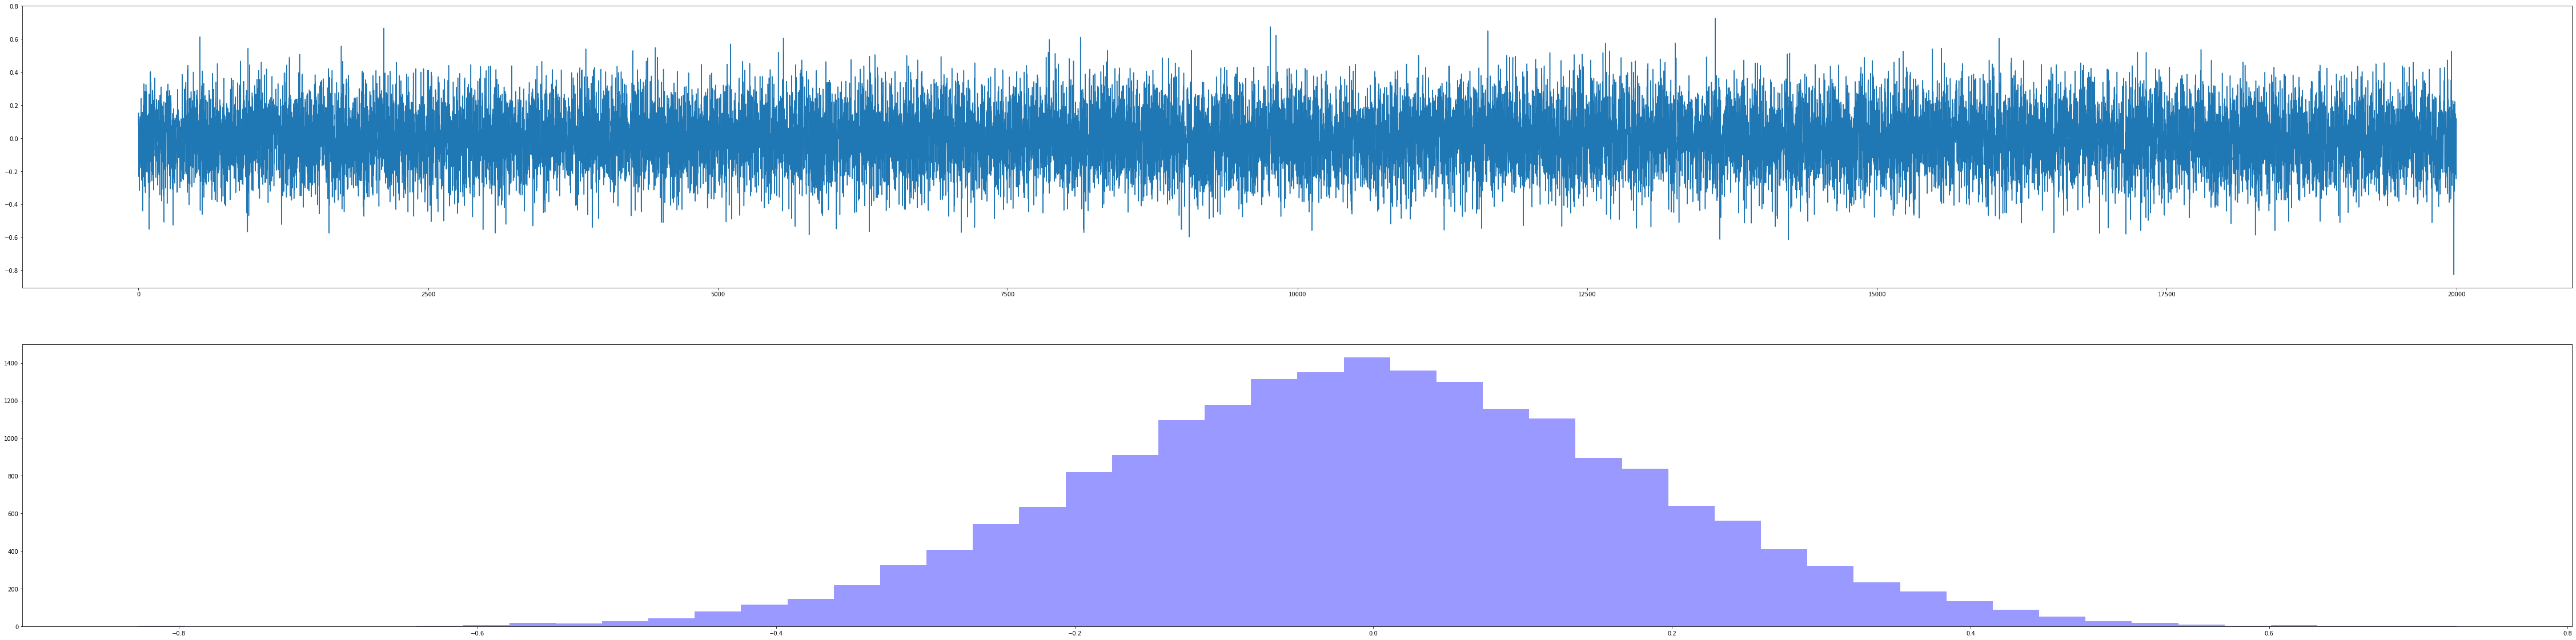

In [10]:
# run for 20k steps, finding the innovation vector 
for i in range(20000): 
   
  '''
  Calculating Process estimates assuming No Attack
  '''
  # calculation of the innovation vector, z. This is being sent to the remote estimator
  zt = y[i] - torch.chain_matmul(C, A, xhat)
  z_innovation.append(zt)
  # estimation of xhat and error covariance matrix using kalman filter.
  # It can be assumed that we are giving zt instead of y[i] to the kalman filter, just to keep consistency with what our system is doing
  xhat, P, Sigma_z = kalman(A, C, Q, R, y[i], q, xhat, P)
  x_estimate.append(xhat)
  P_list.append(P)
  Sigma_z_list.append(Sigma_z)
  detector_values_true.append(torch.chain_matmul(zt.t(), torch.inverse(Sigma_z), zt).item())

Sigma_z_inf = Sigma_z_list[-1]
P_inf = P_list[-1]

fig, axis = plt.subplots(2,1, figsize = (80,20))
axis[0].plot(torch.stack(z_innovation).detach()[:, 0])
sb.distplot(z_innovation, kde =False,color = 'blue', ax = axis[1])
plt.plot()

value of zt * Sigma inv * z where z is unattacked

[]

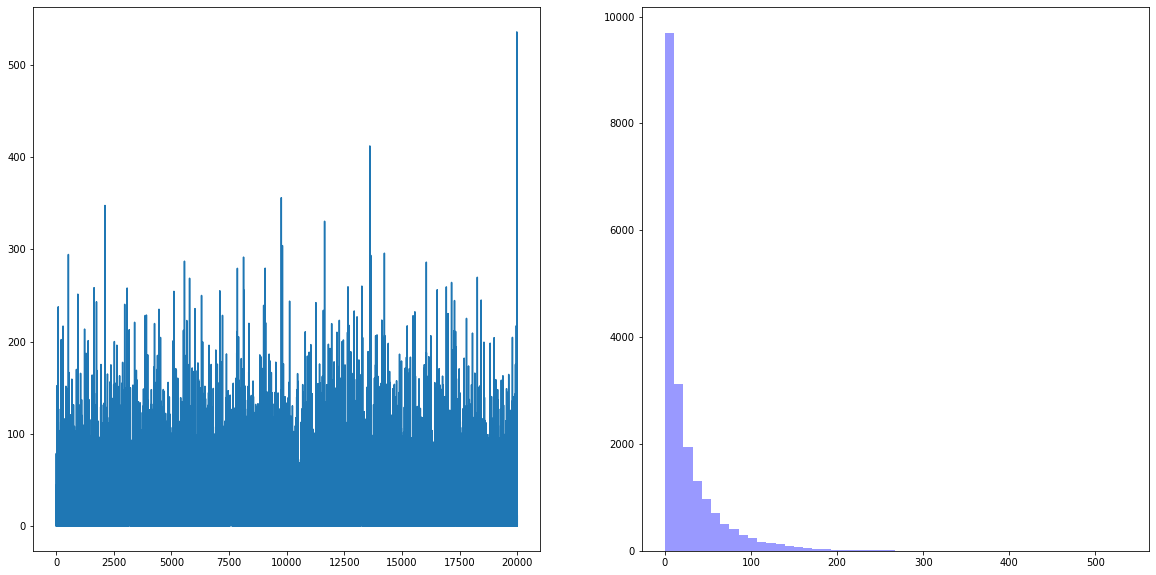

In [11]:
fig, axis = plt.subplots(1,2, figsize = (20,10))
axis[0].plot(detector_values_true)
sb.distplot(detector_values_true, kde =False,color = 'blue', ax = axis[1])
plt.plot()

Training the model with 10k training examples

In [0]:
z_train = loaddata(z_innovation[0:10000], batchsize)
dataiter = iter(z_train)

In [13]:
totalsteps = 10000/batchsize
num_epochs = 1
for epoch in range(num_epochs):
  for i, z_batch in enumerate(z_train):
    # forward prop to get attacked zt
    z_attacked_batch = model(z_batch)

    # find xhat_tilda_batch
    xhat_tilda_batch = FitKalman(z_attacked_batch)

    # calculate loss
    mseloss, chiloss= lossfunction(z_attacked_batch, Sigma_z_inf, xhat_tilda_batch)
    totalloss = 3 * mseloss + chiloss
    # chiloss is zt * Sigmainv * zt avg value for 25 z's
    chiloss_list.append(chiloss.item() / (Lambda))
    # mseloss is x-x * square loss
    mseloss_list.append(mseloss.item() / (mseloss_factor))
    # loss_list.append(totalloss.item())
    loss_list.append((chiloss.item() /(Lambda))+(mseloss.item()/ (mseloss_factor)))

    optimizer.zero_grad() 
    totalloss.backward(retain_graph=True)
    optimizer.step()

    # Lambda

    print('Epoch [{}/{}], Step [{}/ {}], TotalLoss ={},  ChiLoss = {}, mseloss = {}'.format(epoch+1, num_epochs, i, totalsteps, loss_list[-1], chiloss_list[-1], mseloss_list[-1]))

  # '''
  # The Remote estimator calculates process estimates in the case of an attack
  # '''
  # # Attacker calculates the changed value of z by forward proping
  # z_tilda = model(zt.view(1, 1, N * k)).view(N * k, 1)
  # z_attacked.append(z_tilda.clone())
  # detector_values_changed_z.append(torch.chain_matmul(z_tilda.t(), torch.inverse(Sigma_z), z_tilda).item())
  # # calculate y corresponding to attacked value of z
  # y_attacked = z_tilda +  torch.chain_matmul(C, A, xhat_tilda)
  # # find the attacked value of x = xhat_tilda
  # xhat_tilda, P_attacked, Sigma_z_attacked = kalman(A, C, Q, R, y_attacked, q ,xhat_tilda, P_attacked)
  # x_attacked.append(xhat_tilda.clone()) 
  # '''
  # Model Training
  # '''
  # if(i % 50 == 0):

  #   mseloss, chiloss= lossfunction(z_tilda, Sigma_z, xhat_tilda)
  #   totalloss = mseloss + chiloss
  #   chiloss_list.append(chiloss.item())
  #   mseloss_list.append(mseloss.item())
  #   loss_list.append(totalloss.item())

  #   optimizer.zero_grad() 
  #   totalloss.backward(retain_graph=True)
  #   optimizer.step()

Epoch [1/1], Step [0/ 400.0], TotalLoss =98.78741931915283,  ChiLoss = 85.32441139221191, mseloss = 13.463007926940918
Epoch [1/1], Step [1/ 400.0], TotalLoss =53.66277885437012,  ChiLoss = 41.46848678588867, mseloss = 12.194292068481445
Epoch [1/1], Step [2/ 400.0], TotalLoss =24.232775688171387,  ChiLoss = 13.449501991271973, mseloss = 10.783273696899414
Epoch [1/1], Step [3/ 400.0], TotalLoss =10.396133914589882,  ChiLoss = 0.9104762226343155, mseloss = 9.485657691955566
Epoch [1/1], Step [4/ 400.0], TotalLoss =11.054885149002075,  ChiLoss = 2.7395784854888916, mseloss = 8.315306663513184
Epoch [1/1], Step [5/ 400.0], TotalLoss =24.110074758529663,  ChiLoss = 16.823161840438843, mseloss = 7.28691291809082
Epoch [1/1], Step [6/ 400.0], TotalLoss =46.26544237136841,  ChiLoss = 39.85100507736206, mseloss = 6.414437294006348
Epoch [1/1], Step [7/ 400.0], TotalLoss =73.1284761428833,  ChiLoss = 67.42029190063477, mseloss = 5.708184242248535
Epoch [1/1], Step [8/ 400.0], TotalLoss =99.815

For A scalar Process we see that the model is trained to CONVERGE Every value of Z to near 0

[]

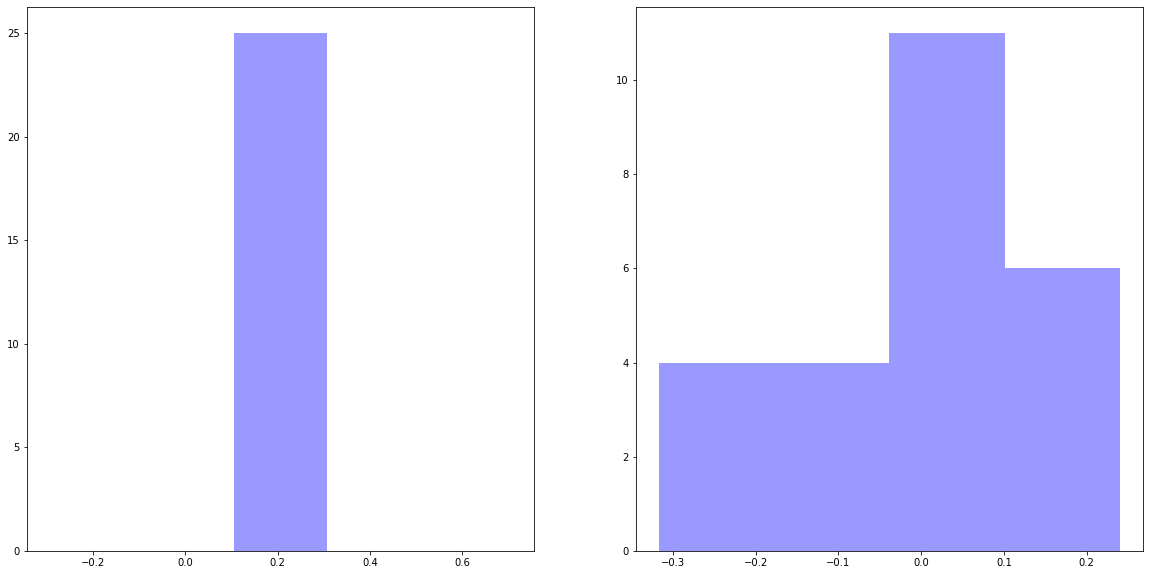

In [14]:
# print(dataiter.next())
batch = dataiter.next()
fig, axis = plt.subplots(1,2, figsize = (20,10))
# axis[0].plot(dataiter.next()[:, 0, 0])
sb.distplot(model(batch).detach()[:, 0, 0], kde =False,color = 'blue', ax = axis[0])
sb.distplot(batch[:, 0, 0], kde =False,color = 'blue', ax = axis[1])
plt.plot()

LOSSES

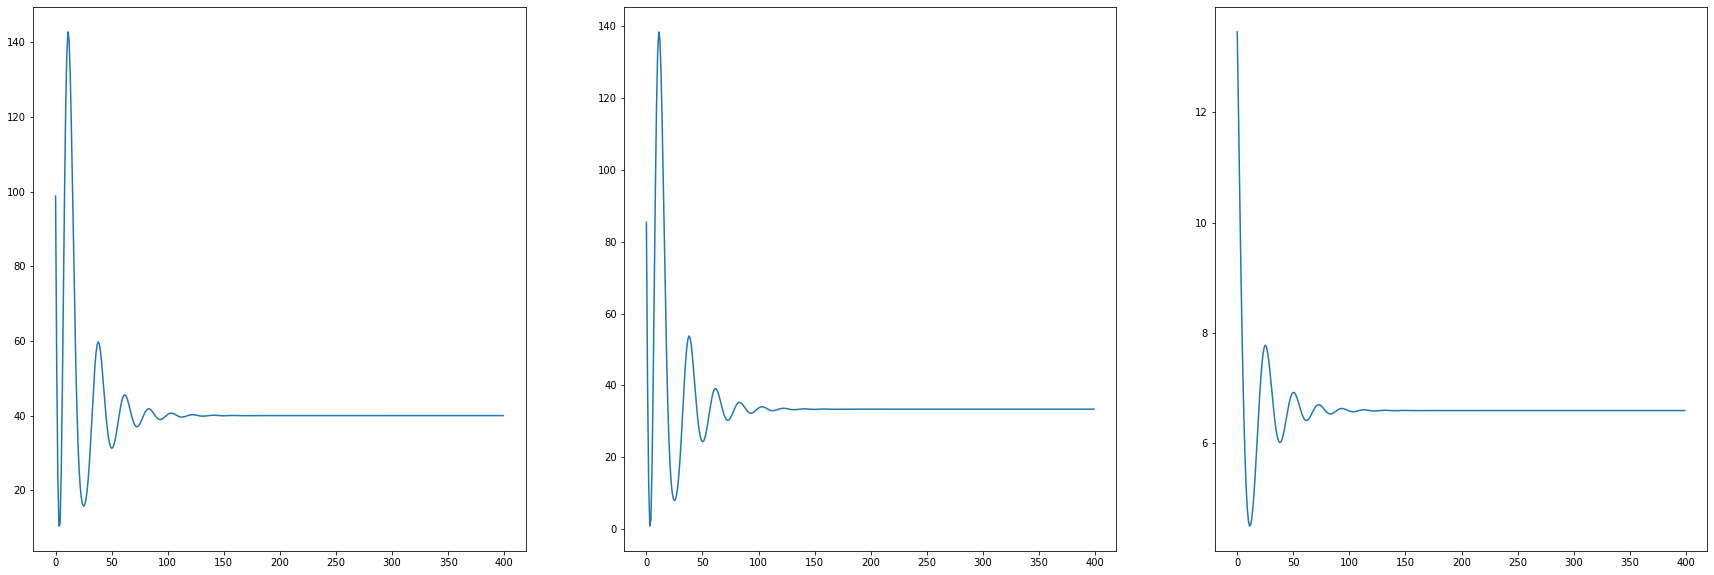

In [15]:

fig, axis = plt.subplots(1,3, figsize = (30,10))
axis[0].plot(loss_list)
axis[1].plot(chiloss_list)
axis[2].plot(mseloss_list)
plt.show()

SOME EVALUATION on the rest 10k data

In [16]:
# evaluate on the next 10000 data as test 

model.eval()
z_test = loaddata(z_innovation[10000:20000], batchsize)
dataiter1 = iter(z_test)

# values to save
loss_list_test = []
mseloss_list_test =[]
chiloss_list_test = []
z_tilda_test_batchavgs = []
z_innovation_test = []
detector_values_true_test = []
xhat_tilda_test_batchavgs = []

totalsteps = 10000/batchsize
for epoch in range(1):
  for i, z_batch in enumerate(z_test):
    # forward prop to get attacked zt
    z_attacked_batch = model(z_batch)
    z_tilda_test_batchavgs.append(z_attacked_batch.sum()/batchsize)

    # find xhat_tilda_batch
    xhat_tilda_batch = FitKalman(z_attacked_batch)
    xhat_tilda_test_batchavgs.append(z_attacked_batch.sum()/batchsize)

    # calculate loss
    mseloss, chiloss= lossfunction(z_attacked_batch, Sigma_z_inf, xhat_tilda_batch)
    totalloss = 200 * mseloss + chiloss
    # chiloss is zt * Sigmainv * zt avg value for 25 z's
    chiloss_list_test.append(chiloss.item() / (Lambda))
    # mseloss is x-x * square loss
    mseloss_list_test.append(mseloss.item() / (mseloss_factor))
    # loss_list.append(totalloss.item())
    loss_list_test.append((chiloss.item() /(Lambda))+(mseloss.item()/ (mseloss_factor)))

    print('Testing .... Epoch [{}/{}], Step [{}/ {}], TotalLoss ={},  ChiLoss = {}, mseloss = {}'.format(epoch+1, num_epochs, i, totalsteps, loss_list[-1], chiloss_list[-1], mseloss_list[-1]))



# for i in range(10000, 20000): 
  
#   '''
#   The Remote estimator calculates process estimates in the case of an attack
#   '''
#   # Attacker calculates the changed value of z by forward proping
#   z_tilda = model(zt.view(1, 1, N * k)).view(N * k, 1)
#   z_attacked_test.append(z_tilda.clone())
#   detector_values_changed_z_test.append(torch.chain_matmul(z_tilda.t(), torch.inverse(Sigma_z), z_tilda).item())
#   # calculate y corresponding to attacked value of z
#   y_attacked = z_tilda +  torch.chain_matmul(C, A, xhat_tilda)
#   # find the attacked value of x = xhat_tilda
#   xhat_tilda, P_attacked, Sigma_z_attacked = kalman(A, C, Q, R, y_attacked, q ,xhat_tilda, P_attacked)
#   x_attacked.append(xhat_tilda.clone()) 

#   '''
#   calculating loss
#   '''
#   mseloss, chiloss= lossfunction(z_tilda, Sigma_z, xhat_tilda)
#   totalloss = mseloss + chiloss
#   loss_list_test.append(totalloss.item())

Testing .... Epoch [1/1], Step [0/ 400.0], TotalLoss =39.996864318847656,  ChiLoss = 33.41278791427612, mseloss = 6.584076404571533
Testing .... Epoch [1/1], Step [1/ 400.0], TotalLoss =39.996864318847656,  ChiLoss = 33.41278791427612, mseloss = 6.584076404571533
Testing .... Epoch [1/1], Step [2/ 400.0], TotalLoss =39.996864318847656,  ChiLoss = 33.41278791427612, mseloss = 6.584076404571533
Testing .... Epoch [1/1], Step [3/ 400.0], TotalLoss =39.996864318847656,  ChiLoss = 33.41278791427612, mseloss = 6.584076404571533
Testing .... Epoch [1/1], Step [4/ 400.0], TotalLoss =39.996864318847656,  ChiLoss = 33.41278791427612, mseloss = 6.584076404571533
Testing .... Epoch [1/1], Step [5/ 400.0], TotalLoss =39.996864318847656,  ChiLoss = 33.41278791427612, mseloss = 6.584076404571533
Testing .... Epoch [1/1], Step [6/ 400.0], TotalLoss =39.996864318847656,  ChiLoss = 33.41278791427612, mseloss = 6.584076404571533
Testing .... Epoch [1/1], Step [7/ 400.0], TotalLoss =39.996864318847656,  C

[]

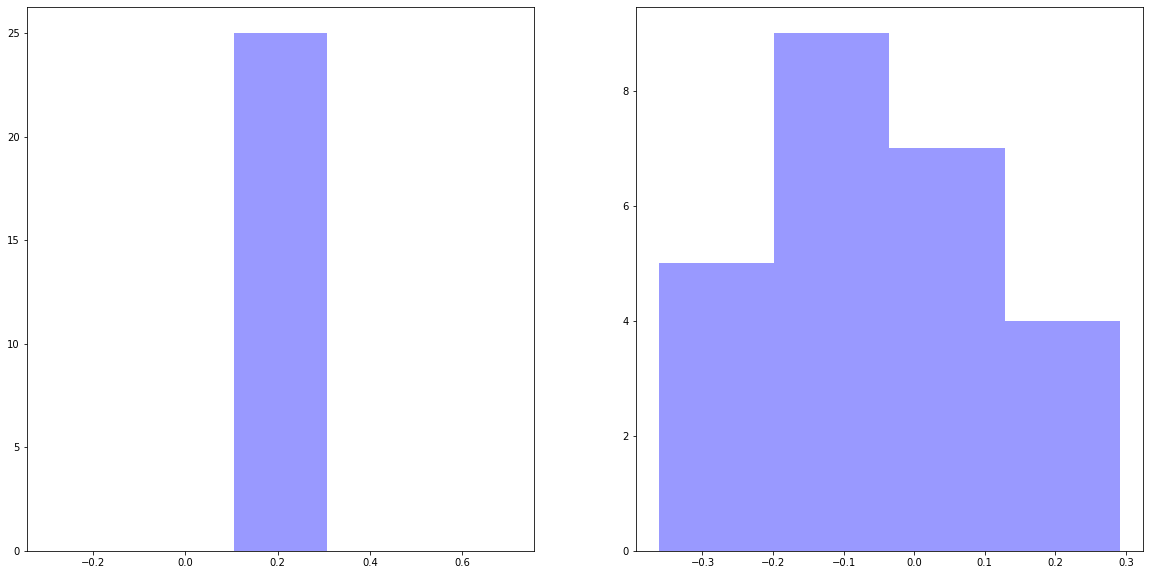

In [17]:
batch = dataiter1.next()
fig, axis = plt.subplots(1,2, figsize = (20,10))
# axis[0].plot(dataiter.next()[:, 0, 0])
sb.distplot(model(batch).detach()[:, 0, 0], kde =False,color = 'blue', ax = axis[0])
sb.distplot(batch[:, 0, 0], kde =False,color = 'blue', ax = axis[1])
plt.plot()

Following Plots show that the loss remains constant

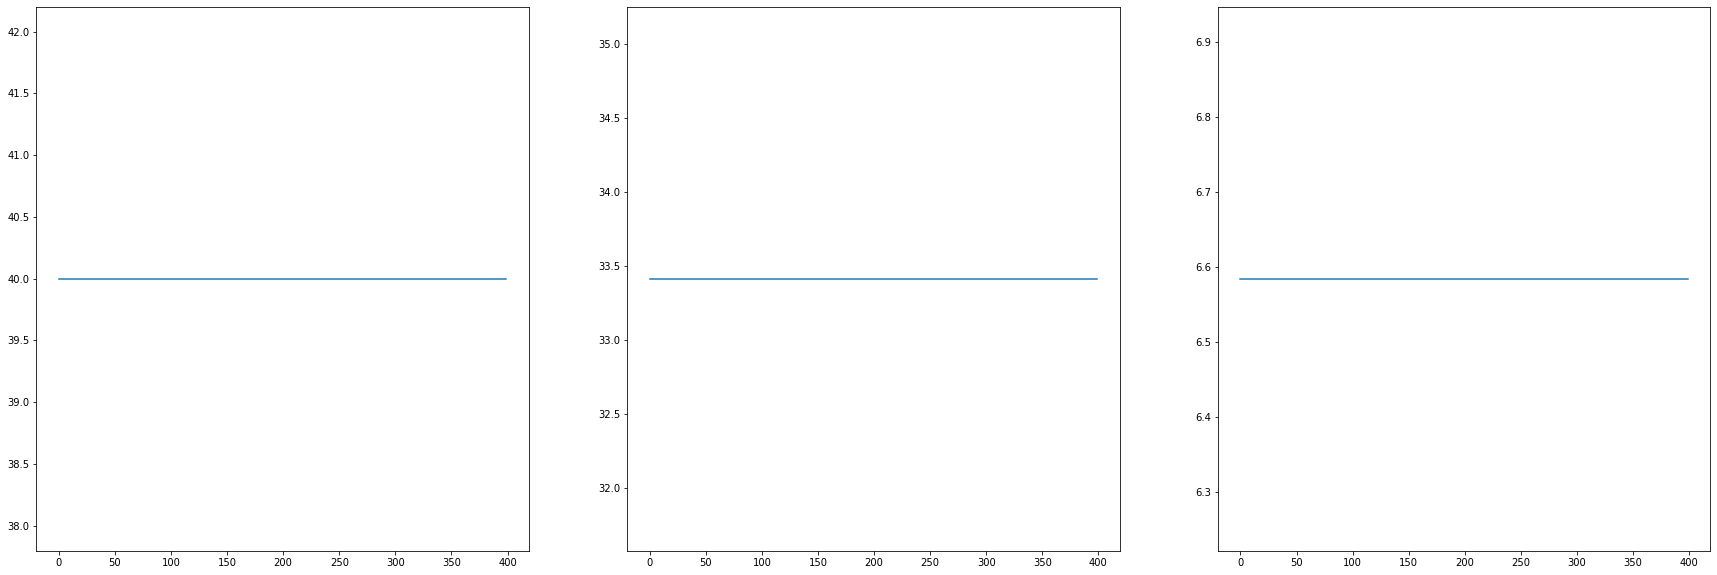

In [18]:
fig, axis = plt.subplots(1,3, figsize = (30,10))
axis[0].plot(loss_list_test)
axis[1].plot(chiloss_list_test)
axis[2].plot(mseloss_list_test)
plt.show()

Z and X both converge to a point.

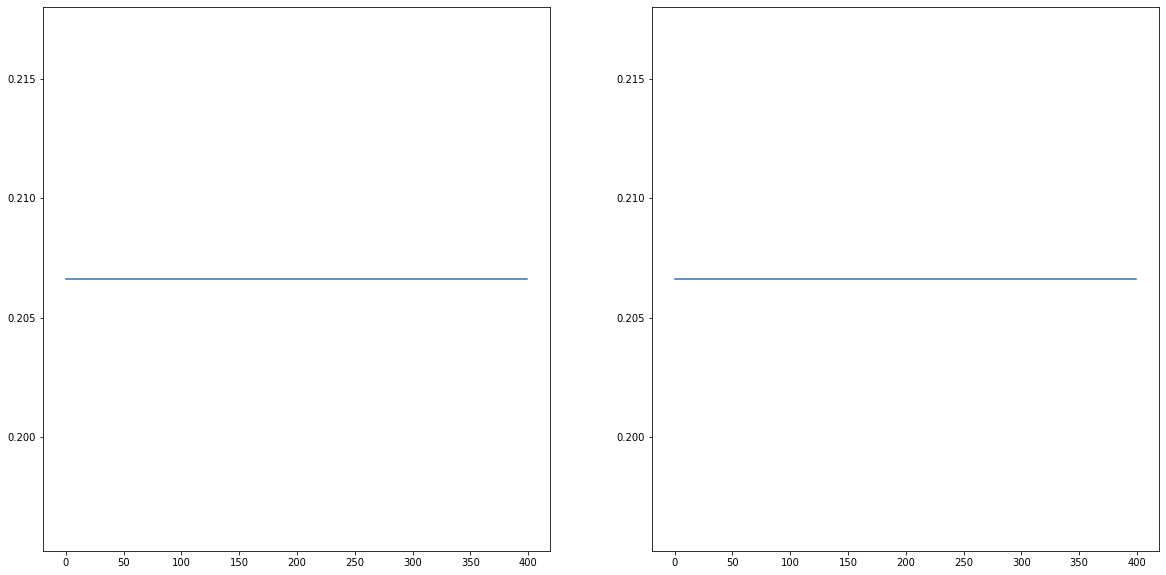

In [19]:
fig, axis = plt.subplots(1,2, figsize = (20,10))
axis[0].plot(z_tilda_test_batchavgs)
axis[1].plot(xhat_tilda_test_batchavgs)
plt.show()

In [20]:
print(z_tilda_test_batchavgs)
print(xhat_tilda_test_batchavgs)

[tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>), tensor(0.2066, grad_fn=<DivBackward0>),